# ResNet9 in Tensorflow - Classifying CIFAR-10 images


In [1]:
# may need to update tensorflow_addons if using google collab
!pip install --upgrade tensorflow_addons
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
%matplotlib inline

# improved speed with mixed precision
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

Requirement already up-to-date: tensorflow_addons in /opt/conda/lib/python3.7/site-packages (0.10.0)


In [0]:
class Conv2DBatchNormReLU(tf.keras.layers.Layer):
    """
    Creates a layer of the form:

    Convolutional layer 2D -> Batch Norm -> ReLU

    Conv layer uses He uniform weight initialization, no bias.
    Uses PyTorch defaults for epsilon and momentum, 2.5e-4 l2 regularization,
    which is equivalent to 5e-5 weight decay coupled to SGD momentum in ResNet9.
    Note: Batch Norm momentum 0.1 in PyTorch is 1.0-0.1 = 0.9 in Tensorflow

Arguments:
    filters (int): number of filters used convolutions, and gives num channels of output tensor
    kernel_size (int or tuple of 2 integers): window size used in convolutions
    input_shape (tuple of 3 integers): only needed if this is the first layer in the network. Use (rows, cols, filters)

Output shape:
    (batch_size, rows, cols, filters)

Returns:
    A tensor of rank 4
    """
    def __init__(self, filters, l2=2.5e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(filters=filters,
                                             kernel_size=kernel_size,
                                             padding='SAME',
                                             use_bias=False,
                                             kernel_initializer=tf.keras.initializers.he_uniform(),
                                             kernel_regularizer=tf.keras.regularizers.l2(l2))
        self.batch_norm = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9,
                                                              beta_regularizer=tf.keras.regularizers.l2(l2), 
                                                              gamma_regularizer=tf.keras.regularizers.l2(l2))
      
    def call(self, inputs, training=False):
        x = self.conv2d(inputs)
        # From documentation: training=False (in call - not in layer!) 
        # layer will normalize its inputs using the mean and variance of its 
        # moving statistics, learned during training
        x = self.batch_norm(x, training=training)
        x = tf.nn.relu(x)
        return x

class ResNet9Block(tf.keras.layers.Layer):
    """
    Creates a Residual Block of type used in the network in https://github.com/davidcpage/cifar10-fast 
    (see demo.ipynb). Structure:

    Let CBR = Convolutional layer 2D -> Batch Norm -> ReLU
    Let x = CBR -> Pooling Layer (factor of 2)

    Then the structure is (x -> CBR -> CBR) + x

    Arguments:
        filters (int): number of filters used in all convolutions, and gives num channels of output tensor
        kernel_size (int or tuple of 2 integers): window size used in all convolutions
        input_shape (tuple of 3 integers): only needed if this is the first layer in the network. Use (rows, cols, filters)

    Output shape:
        (batch_size, rows/2, cols/2, filters)

    Returns:
        A tensor of rank 4
    """
    def __init__(self, filters, l2=2.5e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv_bn_relu_1 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.conv_bn_relu_2 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.conv_bn_relu_3 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.max_pool2d = tf.keras.layers.MaxPool2D()

    def call(self, inputs, training=False, **kwargs):
        """
        Residual behaviour implemented here.
        """
        x = self.conv_bn_relu_1(inputs)
        x = self.max_pool2d(x)
        y = self.conv_bn_relu_2(x)
        y = self.conv_bn_relu_3(y)
        x = x + y
        return x

## Augment

In [0]:
class NormalizeZscore:
    """
    Normalize numpy array of images by z-score, independently for each channel.
    Note: converts to float32 and not the default of float 64, 
    and rounds to 2 decimal places as was done in their implementation.

    Attributes:
        self.means (numpy array) = list of means, calculated across dataset. one mean per channel
        self.stds (numpy array) = list of stds, calculated across dataset. one std per channel
    
    Methods:
        self.fit = calculate means and stds of train dataset and store as class attribute
        self.transform = normalize dataset by z-score
    """
    def __init__(self):
        self.means = None
        self.stds = None

    def fit(self, train_dataset):
        self.means = np.mean(train_dataset, axis=(0,1,2), dtype=np.float32)
        self.stds = np.std(train_dataset, axis=(0,1,2), dtype=np.float32)
        # round to 2 decimal place to match their implementation
        self.means = np.around(self.means, 2)
        self.stds = np.around(self.stds, 2)
        return None

    def transform(self, dataset):
        dataset = (dataset - self.means)/self.stds
        return dataset

def pad(images, padding=4):
    """
    Pads images above, below, left, right with default 4 pixels.
    Use on 4D numpy arrays of shape (batch_size, height, width, channels). 
    """
    return np.pad(images, [(0, 0), (padding, padding), (padding, padding), (0, 0)], mode='reflect')

@tf.function # decorate to improve performance
def augment(images, labels, batch_size=512, cutout_dim=[8,8]):
    """
    Random crop to 32x32, apply random LR flip, apply random 8x8 cutout.
    Needs package tensorflow_addons for cutout.
    Use on 4D image (batch_size, height, width, channels) 
    Use on datasets created with images paired with labels ie.

    dataset = tf.from_tensor_slices((images, labels))
    """
    images = tf.image.random_crop(images, size=[tf.shape(images)[0], 32, 32, 3])
    images = tf.image.random_flip_left_right(images)
    images = tfa.image.random_cutout(images, mask_size=cutout_dim)
    return images, labels

## Check Augmentation worked

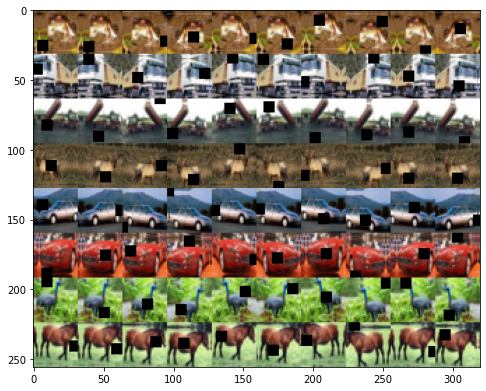

In [4]:
# need the to use augment implementation with smaller than default batch size
from functools import partial

# modified from https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/
def plot_augmented_images(dataset, n_images, samples_per_image):
    """
    Checks what repeated calls to the dataset do by plotting a grid of images.

    1. If not using .batch already in the dataset, need to modify the iterator here
    by writing 
    
    for images in dataset.repeat(samples_per_image).batch(n_images):

    2. If .batch is already being used as a method on the dataset, then this is the number of images
    that will be displayed and

    for images in dataset.repeat(samples_per_image):
    
    should be used. The correct n_images=batch_size also needs to be passed as 
    argument to the function in this second case.
    """
    # initialize output array
    output = np.zeros((32*n_images, 32*samples_per_image, 3))

    row = 0
    for images, labels in dataset.repeat(samples_per_image): #.batch(n_images):
        # replace row in output array with several transforms of the image
        output[:, row*32:(row+1)*32, :] = np.vstack(images.numpy())
        row += 1

    plt.figure(figsize=(8,8))
    plt.imshow(output)
    plt.savefig('augmented.png')
    plt.show()

# get data and test augmentation
(train, train_labels), (test, test_labels) = tf.keras.datasets.cifar10.load_data()

# visualize augmentation on a few images
n_images = 8

# pad with 4 pixels 
train_sample = pad(train[0:n_images], padding=4)

# need to convert to float32 from int8 and normalize to visualize augmentation
train_sample = (train_sample/255).astype(np.float32)
train_sample_labels = train_labels[0:n_images]

# convert to tensorflow datasets and apply pad, crop, cutout via .map(augment, ..)
train_sample_dataset = tf.data.Dataset.from_tensor_slices((train_sample, train_sample_labels))

# use a different batch_size from default of 512
augment_small_batch = partial(augment, batch_size=8)

augmented_train_sample_dataset = (train_sample_dataset
                                  .batch(n_images)
                                  .map(augment_small_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                  )

plot_augmented_images(augmented_train_sample_dataset, n_images=n_images, samples_per_image=10)

## Train


Epoch 00001: LearningRateScheduler reducing learning rate to 0.08.
Epoch 1/24
97/97 [==============================] - 4s 43ms/step - loss: 3.0397 - accuracy: 0.4963 - lr: 0.0800

Epoch 00002: LearningRateScheduler reducing learning rate to 0.16.
Epoch 2/24
97/97 [==============================] - 4s 43ms/step - loss: 2.4689 - accuracy: 0.6562 - lr: 0.1600

Epoch 00003: LearningRateScheduler reducing learning rate to 0.24.
Epoch 3/24
97/97 [==============================] - 4s 42ms/step - loss: 2.0652 - accuracy: 0.7304 - lr: 0.2400

Epoch 00004: LearningRateScheduler reducing learning rate to 0.32.
Epoch 4/24
97/97 [==============================] - 4s 43ms/step - loss: 1.7021 - accuracy: 0.7784 - lr: 0.3200

Epoch 00005: LearningRateScheduler reducing learning rate to 0.4.
Epoch 5/24
97/97 [==============================] - 4s 42ms/step - loss: 1.4265 - accuracy: 0.8031 - lr: 0.4000

Epoch 00006: LearningRateScheduler reducing learning rate to 0.3793157894736842.
Epoch 6/24
97/97 [=

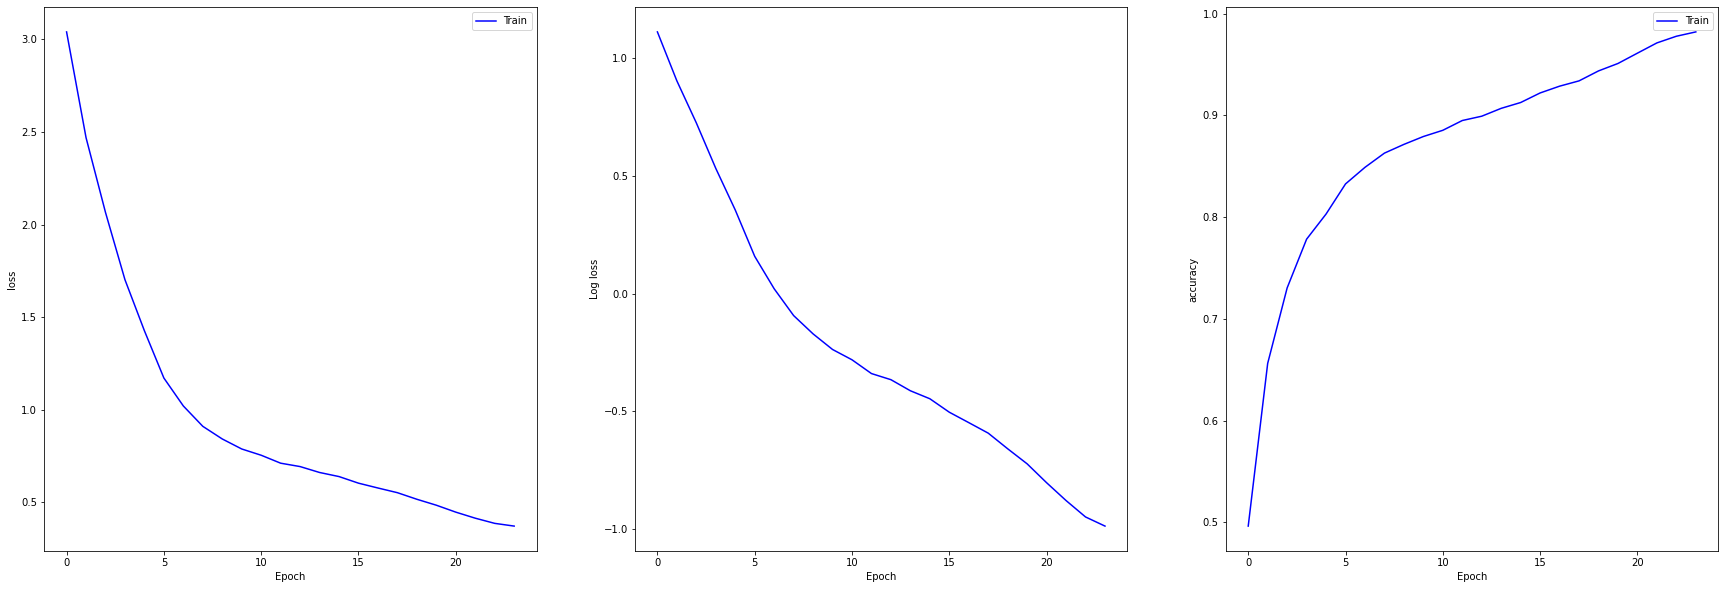

In [5]:
# Build the model 
# Structure, sizes of filters, convolutional kernels, pooling sizes 
# can be found at https://github.com/davidcpage/cifar10-fast/blob/master/demo.ipynb

# if memory filling on multiple runs
tf.keras.backend.clear_session()

start_time = timer()

# Their implementation multiplies logits by 0.125 
# We'll use this as the activation function for the final fully connected layer
@tf.function
def scalar_multiply(x):
    return 0.125*x

model = tf.keras.models.Sequential([
    Conv2DBatchNormReLU(filters=64, input_shape=(32,32,3)),
    ResNet9Block(filters=128),
    Conv2DBatchNormReLU(filters=256),
    tf.keras.layers.MaxPool2D(2),
    ResNet9Block(filters=512),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, use_bias=False, activation=scalar_multiply, 
    # 2.5e-4 l2 is equivalent to their use of 5e-4 weight decay coupled
    # to SGD momentum
                          kernel_regularizer=tf.keras.regularizers.l2(2.5e-4),
                          kernel_initializer=tf.keras.initializers.he_uniform())
])

batch_size = 512
num_epochs = 24
warmup_epochs = 5
max_learning_rate = 0.4

# learning rate initially linearly increases, then decreases linearly
learning_rates = list(np.linspace(0.08, max_learning_rate, warmup_epochs-1, endpoint=False)) 
learning_rates += list(np.linspace(max_learning_rate, 0.007, num_epochs-warmup_epochs+1, endpoint=True))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learning_rates[epoch], verbose=1)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# get data
(train, train_labels), (test, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = train_labels.squeeze()

# normalize by z-score, fitting parameters from train, pad height, width with 4 pixels
zscore = NormalizeZscore()
zscore.fit(train)
train = zscore.transform(train)
train = pad(train, padding=4)
train_length = np.shape(train)[0]

# create datasets and set up on the fly augmentation for training
train_dataset = tf.data.Dataset.from_tensor_slices((train, train_labels))
train_dataset = (train_dataset
                 .cache()
                 # repeat before shuffle provides better performance
                 # shuffle before repeat provides stronger ordering guarantees (no epoch boundary blurring)
                 # may want to change shuffle buffer size - larger buffers mean more random, worse performance
                 .shuffle(50000, reshuffle_each_iteration=True)  
                 .repeat()
                 .batch(batch_size)
                 .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                  )

# train
model_fit = model.fit(train_dataset,
                          epochs=num_epochs,
                          # specify steps because .repeat() repeats indefinitely
                          steps_per_epoch=train_length//batch_size, 
                          callbacks=[lr_schedule]
)

end_time = timer()
print(f'Elapsed time is {end_time-start_time} seconds.')

print('Training complete')

def plot_loss(model_fit):
    figure, axes = plt.subplots(1, 3, figsize=(30,10)) 
    for i, metric in enumerate(['loss', 'accuracy']):
        axes[2*i].plot(model_fit.epoch, model_fit.history[metric], color='b', label='Train')
        axes[2*i].set(xlabel='Epoch', ylabel=metric)
        axes[2*i].legend()
    axes[1].plot(model_fit.epoch, np.log(model_fit.history['loss']), color='b', label='Train')
    axes[1].set(xlabel='Epoch', ylabel="Log loss")
    plt.savefig('metrics.png')
    plt.show()

plot_loss(model_fit)

## Test performance


In [6]:
# Normalize test and convert to dataset
test = zscore.transform(test)
test_dataset = tf.data.Dataset.from_tensor_slices((test, test_labels)) 
test_dataset = (test_dataset
                      .batch(batch_size)
                      .prefetch(tf.data.experimental.AUTOTUNE)
                      )

metric_values = model.evaluate(test_dataset)
print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

20/20 [==============================] - 0s 15ms/step - loss: 0.4877 - accuracy: 0.9408
Final TEST performance
loss: 0.48767924308776855
accuracy: 0.9408000111579895


# Their Implementation

In [0]:
!git clone -q https://github.com/davidcpage/cifar10-fast.git
!cd cifar10-fast && python -m dawn --data_dir=~/data